# Anisotropic stresses

This notebook demonstrates the calculation of anisotropic stresses of injected oil droplets. The measure properties included the following:

* $\sigma^A(\vec{x}_s)$: anisotropic stress on surface
* $\sigma^A_T(\vec{x}_s)$: anisotropic stress on fitted ellipsoid (e.g. tissue-level)

In [1]:
import napari
import napari_stress
from napari_stress import measurements, approximation
import matplotlib.pyplot as plt

import numpy as np

## config

We need to set some parameters:

* `max_degree`: Degree of the spherical harmonics expansion. See also [glossary](spherical_harmonics:mathematical_basics:degree).
* $\gamma$-value: [Interfacial surface tension](https://en.wikipedia.org/wiki/Surface_tension) of an injected oil droplet in $\frac{mN}{m}$

In [2]:
max_degree = 5
gamma = 26.0

In [3]:
# Get some sample data
pointcloud = napari_stress.get_droplet_point_cloud()[0]

In [4]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.


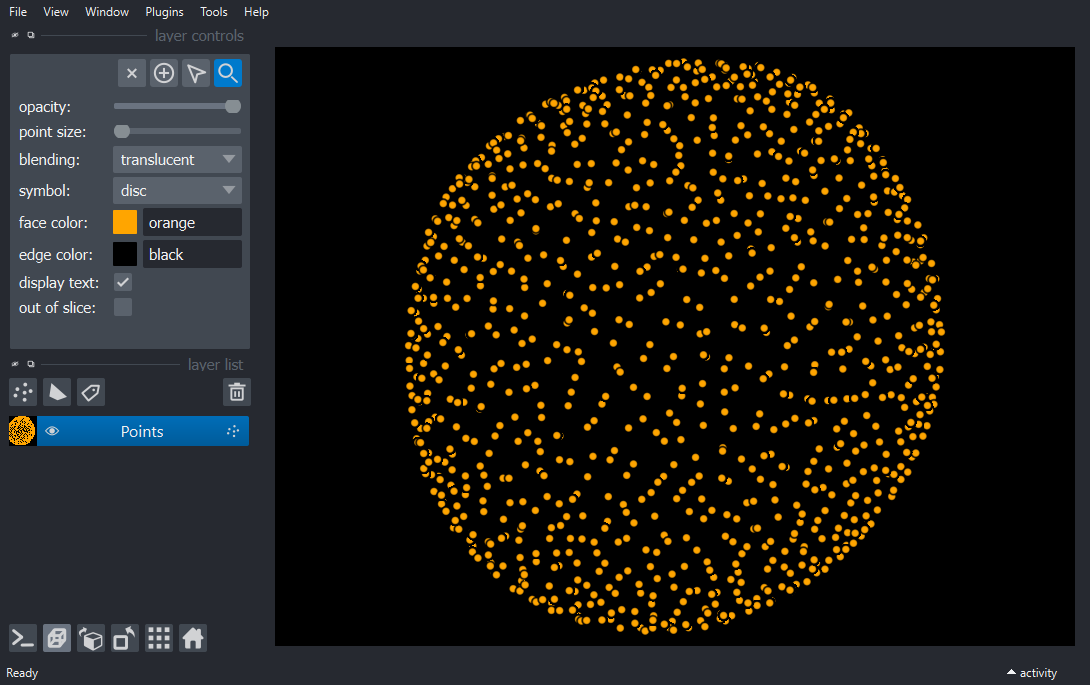

In [5]:
layer_raw = viewer.add_layer(napari.layers.Layer.create(data = pointcloud[0], meta=pointcloud[1], layer_type=pointcloud[2]))
napari.utils.nbscreenshot(viewer)

## Ellipsoid fit

First, we fit an ellipsoid to the pointcloud. The ellipsoid represents the tissue-scale stresses.

In [6]:
fitted_ellipsoid = approximation.least_squares_ellipsoid(pointcloud[0])
fitted_ellipse_points = approximation.expand_points_on_ellipse(fitted_ellipsoid, pointcloud[0])

We then measure the curvatures on every point on the surface:

In [7]:
curvature_on_ellipsoid = measurements.curvature_on_ellipsoid(fitted_ellipsoid, fitted_ellipse_points)
H_ellipsoid_major_medial_minor = curvature_on_ellipsoid[1]['metadata']['H_ellipsoid_major_medial_minor']

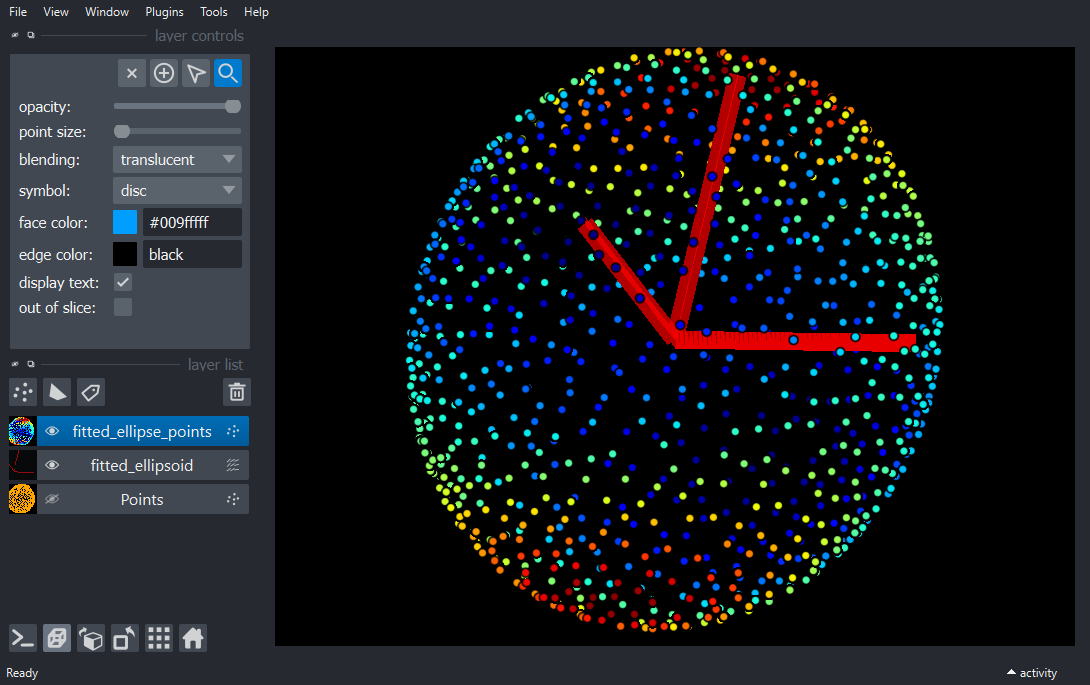

In [8]:
layer_raw.visible = False
ellipsoid_layer = viewer.add_vectors(fitted_ellipsoid)
viewer.add_points(fitted_ellipse_points, features = curvature_on_ellipsoid[1]['features'], face_color = 'mean_curvature', size=0.5, face_colormap = 'jet')
napari.utils.nbscreenshot(viewer)

We now do a spherical harmonics expansion of the ellipsoid points. From this, we can then calculate the average mean curvature $H_0$ and the mean curvature $H_i$ at every point on the surface.

In [9]:
fitted_ellipse_points_spherical_harmoniocs = napari_stress.fit_spherical_harmonics(fitted_ellipse_points, max_degree=max_degree)
coefficients = fitted_ellipse_points_spherical_harmoniocs[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=500, use_minimal_point_set=False)
manifold_ellipsoid = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

*Note*: $H_0$ is calculated using the spherical-harmonics related curvature definition. The point-wise curvature $H_i$ is derived by projecting the quadrature points on the surface of the ellipsoid and using the respective measurement function:

In [10]:
_, _, H0_ellipsoid = measurements.calculate_mean_curvature_on_manifold(manifold_ellipsoid)

quadrature_points_on_ellipsoid = approximation.expand_points_on_ellipse(fitted_ellipsoid, quadrature_points)
mean_curvature_ellipsoid = measurements.curvature_on_ellipsoid(fitted_ellipsoid, quadrature_points_on_ellipsoid)[1]['features']['mean_curvature']

## Spherical harmonics expansion

We now do a spherical harmonics expansion of the raw pointcloud. This also captures the higher orders of curvature on the surface of the droplet.

In [11]:
fitted_points = napari_stress.fit_spherical_harmonics(pointcloud[0], max_degree=max_degree)
fitted_points_layer = viewer.add_points(fitted_points[0], **fitted_points[1], name='spherical harmonics expansion')

In [12]:
coefficients = fitted_points[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=500, use_minimal_point_set=False)
manifold_droplet = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [13]:
mean_curvature_spherical_harmonics, _, H0_surface_integral_spherical_harmonics = measurements.calculate_mean_curvature_on_manifold(manifold_droplet)

## Stresses

We first calculate the tissue stress tensors along the ajor axes of the ellipsoid and the cartesian cardinal directions (x/y/z). For this, we need the orientation of the fitted ellipsoid:

In [14]:
orientation_matrix = fitted_ellipsoid[:, 1].T
orientation_matrix = orientation_matrix / np.linalg.norm(orientation_matrix, axis=0)
orientation_matrix

array([[ 0.42328526, -0.80189621, -0.42165396],
       [-0.88138989, -0.47220416,  0.01323211],
       [ 0.20971753, -0.36604058,  0.90666027]])

In [15]:
ellptical, cartesian = measurements.tissue_stress_tensor(H_ellipsoid_major_medial_minor, H0_ellipsoid, orientation_matrix, gamma=gamma)

Secondly, we calculate the anisotropic stress for every point on the surface:

In [16]:
stress, stress_tissue, stress_droplet = measurements.anisotropic_stress(mean_curvature_spherical_harmonics, H0_surface_integral_spherical_harmonics,
                                                                        mean_curvature_ellipsoid, H0_ellipsoid,
                                                                        gamma=gamma)

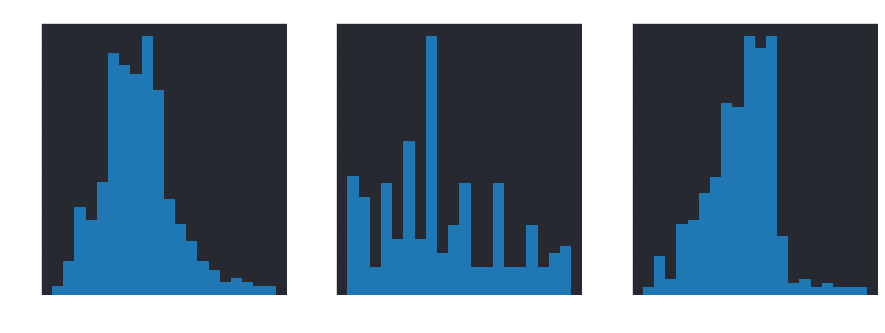

In [17]:
nbins = 20
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].hist(stress, nbins)
axes[0].set_title('Stress')
axes[1].hist(stress_tissue, nbins)
axes[1].set_title('tissue-scale stresses')
axes[2].hist(stress_droplet, nbins)
axes[2].set_title('Cell scale stresses')

for ax in axes:
    ax.set_xlabel('anisotropic stress [mN/m]')
    ax.set_ylabel('Occurrences [#]')